# Distinct element estimation using k-th min 

In the lecture, we studied the algorithm named Idealized $F_0$ estimation (slide 19). The algorithm uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$. We will use the results from exercise 4 to conduct experiments to see how different $k$ values affect the accuracy of your estimate.

[Optional]: Let m be the length of the stream. You can maintaining the k-th smallest element in an unsorted list in time $O(m\log k)$ using min heap, see https://docs.python.org/3/library/heapq.html. 

In [1]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, use modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [2]:
import sys
MAXINT = sys.maxsize

In [70]:
def kth_smallest_hash_value(input_list, k):
    smallest = []
    for i in input_list:
        h = (hash(i) % MAXINT) / MAXINT
        smallest = sorted(smallest + [h])
        if len(smallest) > k:
            smallest = smallest[0:k]
    return smallest[-1]

Now let us test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` you implemented. For each k, repeat this process 100 times and record the average and std of the estimates. Finally, generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so you may need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

In [71]:
# sample the data

testy = []

for k in range(1,11):
    sample = []
    for s in range(100):
        input_list = []
        for i in range(1000):
            input_list.append(str(random.uniform(0,100)))
        sample.append(kth_smallest_hash_value(input_list, k))
    testy.append(sample)

# for each k, take all elements in that sample and compute estimate
testimates = [[k/element for element in testy[k-1]] 
                         for k in range(1,11)]

print(testimates)

[[2264.9023718127214, 1318.7262505013405, 1362.4777702368515, 6234.799677387982, 3519.842699468227, 1004.8649393529206, 2764.1229230323065, 4804.073851658574, 558.165611766005, 615.9572683345481, 4502.423609316465, 860.9563886666574, 18145.303770106824, 1528.5407001070794, 10211.729560906895, 1244.3233035344665, 10472.26496856261, 377.1222588837248, 1729.5064698396257, 9901.258594952738, 1931.1238265528002, 1394.5810225350554, 7730.438052537888, 2413.998629959547, 1014.4275699629076, 435.47677092387653, 365895.926239314, 2277.104385073107, 855.7239767366091, 1803.0793009432152, 6588.538127674834, 16075.130393726422, 317.18156360142325, 2914.7899003361435, 11478.308242875388, 92630.32286663885, 1818.0396259297875, 5817.91664678726, 1609.8503420762415, 235.3746440937815, 1131.713044770833, 1311.606985670527, 304.930313738696, 2056.3702874556648, 569.4279920699927, 462.0810038870896, 1899.9059837693744, 388.8229167167732, 1261.2651888903338, 3095.277570413474, 2982.603439810816, 875.63190

In [82]:
# compute relevant statistics

# [k/sample[k-1] for sample in testy]

testi_means = [np.mean(e) for e in testimates]
testi_stdev = [np.std(e) for e in testimates]

# print(testi_means, testi_stdev)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


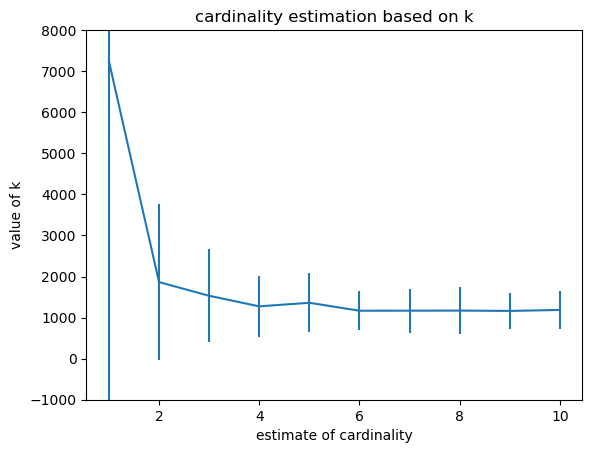

In [88]:
# plot with error bars.
fig, ax = plt.subplots()

plt.errorbar(np.linspace(1,10,10), testi_means, yerr=testi_stdev)
plt.xlabel('estimate of cardinality')
plt.ylabel('value of k')
plt.ylim(-1000, 8000)

ax.set_title('cardinality estimation based on k')

plt.show()

## The median trick useful technique (slide 13)

Please implement the function ``median_trick`` below. 

In [87]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    # Write your code here

Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``. Please generate two plots below. 

- Set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; repeat the estimation 100 times for each delta value. Generate a plot with std as error bars to show how the average estimates change as the delta changes.

- Set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value. Generate a plot with std as error bars to show how the average estimates change as the epsilon changes.

In [ ]:
# Don't change
def normal_generator():
    return np.random.normal(2,1)

In [ ]:
# Write your code here


## Morris Algorithm (slide 45)

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter (slide 51). Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, let us implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [ ]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''


Now let us test the function with the edge list file "soc-hamsterster.edges" in the same folder. Reading the file line by line in python can generate a stream of strings. Counting the number of strings/lines in this file tells us the number of edges of this "soc-hamsterster" graph. Let us try different alpha values ranging from 2 to 9. Again, for each alpha, estimate the number of lines in the edge list file using the morris algorithm (the key component of which is ``morris_update_base_alpha``), and repeat this 100 times. Besides, check how many bits are needed to maintain the counter via ``math.ceil(math.log(counter, 2))`` at the end of each estimation. Finally, generate two plots with std as error bars to show 

- How the average estimate changes as the alpha value increases. 
- How the space usage (in bits) changes as the alpha value increases.